In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#from utils import mnist, plot_graphs, plot_mnist, to_onehot
import numpy as np
import os 

%matplotlib inline

In [44]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
# utils
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler


mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
           ])

def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


def plot_mnist(images, shape, show=True, save_to=None):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

    if save_to is not None:
        plt.savefig(save_to)
        
    if show:
        plt.show()
    else:
        plt.close()

    
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()
        
        
def to_onehot(x, n, device=None):
    if isinstance(x, np.ndarray):
        x = torch.Tensor(x).to(torch.long)
    one_hot = torch.zeros((x.shape[0], n))
    one_hot.scatter_(1, x[:, None], 1.)
    if device is not None:
        one_hot = one_hot.to(device)
    return one_hot

In [45]:
root_folder = 'FC_AAE_CLSF_results'
fixed_folder = root_folder + '/Fixed_results/'
recon_folder = root_folder + '/Recon_results/'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(recon_folder)

In [46]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                lambda x: x.to(device)
           ])

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

lr = 0.0001
prior_size = 10
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((10, prior_size)).repeat((1,10)).view(-1, prior_size).to(device)
fixed_z_label = to_onehot(torch.tensor(list(range(10))).repeat((10)), 10).to(device)
fixed_data, fixed_label = next(iter(test_loader))
fixed_data = fixed_data[:100].to(device)
fixed_label = to_onehot(fixed_label[:100], 10).to(device)

cpu


In [48]:
data, label = next(iter(train_loader))

In [49]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, 
                 last_fn=None, first_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x, y=None):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [96]:
Enc = FullyConnected([28*28, 1024, 1024, prior_size], activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)
Dec = FullyConnected([prior_size+10, 1024, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh(), device=device)
Disc = FullyConnected([prior_size, 1024, 1024, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), device=device)

Enc_optimizer = optim.Adam(Enc.parameters(), lr=lr)
Dec_optimizer = optim.Adam(Dec.parameters(), lr=lr)
Disc_optimizer = optim.Adam(Disc.parameters(), lr=lr)

Enc_true = FullyConnected([28*28, 1024, 1024, prior_size], activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)
Dec_true = FullyConnected([prior_size+10, 1024, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh(), device=device)

Disc_true = FullyConnected([prior_size+10, 1024, 1024, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), device=device)

Enc_true_optimizer = optim.Adam(Enc_true.parameters(), lr=lr)
Dec_true_optimizer = optim.Adam(Dec_true.parameters(), lr=lr)
Disc_true_optimizer = optim.Adam(Disc_true.parameters(), lr=lr)


In [97]:
Disc_true

FullyConnected(
  (model): Sequential(
    (0): Linear(in_features=20, out_features=1024, bias=True)
    (1): Dropout(p=0.3)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): Dropout(p=0.3)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [51]:
train_log = {'E': [],'AE': [], 'D': []}
test_log = {'E': [],'AE': [], 'D': []}

In [52]:
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [53]:
def train(epoch, Enc, Dec, Disc, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, label) in enumerate(train_loader):
        label = to_onehot(label, 10, device)
        # train D
        Enc.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size)).to(device)
        z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)

        fake_pred = Disc(Enc(data))
        true_pred = Disc(z)
        

        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        Disc_loss = 0.5*(fake_loss + true_loss)
        
        Disc_loss.backward()
        Disc_optimizer.step()
        
        # train AE
        Enc.zero_grad()
        Dec.zero_grad()
        Disc.zero_grad()
        
        
        latent = Enc(data)
        reconstructed = Dec(latent, label).view(-1, 1, 28, 28)
        fake_pred = Disc(latent)
        
        Enc_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        AE_loss = F.mse_loss(reconstructed, data)
        G_loss = AE_loss + Enc_loss
        
        G_loss.backward()
        Dec_optimizer.step()
        Enc_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
        print(line + losses)
        log['E'].append(Enc_loss.item())
        log['AE'].append(AE_loss.item())
        log['D'].append(Disc_loss.item())

In [105]:
def train_true(epoch, Enc_true, Dec_true, Disc_true, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, label) in enumerate(train_loader):
        label = to_onehot(label, 10, device)
        # train D
        Enc_true.zero_grad()
        Disc_true.zero_grad()
        
        z = torch.randn((batch_size, prior_size)).to(device)
        z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)


        fake_pred = Disc_true(Enc_true(data), label)
        true_pred = Disc_true(z, z_label)

        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        Disc_true_loss = 0.5*(fake_loss + true_loss)
        
        Disc_true_loss.backward()
        Disc_true_optimizer.step()
        
        # train AE
        Enc_true.zero_grad()
        Dec_true.zero_grad()
        Disc_true.zero_grad()

        
        latent = Enc_true(data)
        reconstructed = Dec_true(latent, label).view(-1, 1, 28, 28)
        fake_pred = Disc_true(latent, label)
        
        Enc_true_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        AE_loss = F.mse_loss(reconstructed, data)
        G_loss = AE_loss + Enc_true_loss
        
        G_loss.backward()
        Dec_true_optimizer.step()
        Enc_true_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_true_loss.item(), AE_loss.item(), Disc_true_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_true_loss.item(), AE_loss.item(), Disc_true_loss.item())
        print(line + losses)
        log['E'].append(Enc_true_loss.item())
        log['AE'].append(AE_loss.item())
        log['D'].append(Disc_true_loss.item())

In [106]:
def test(Enc, Dec, Disc, loader, epoch, log=None):
    test_size = len(loader)
    E_loss = 0.
    AE_loss = 0.
    D_loss = 0.
    test_loss = {'E': 0., 'AE': 0., 'D': 0.}
    with torch.no_grad():
        for data, label in loader:
            label = to_onehot(label, 10, device)
            z = torch.randn((batch_size, prior_size)).to(device)
            z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)
            latent = Enc(data)
            reconstructed = Dec(latent, label).view(-1, 1, 28, 28)
            fake_pred = Disc(latent)
            true_pred = Disc(z)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            E_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
            AE_loss += F.mse_loss(reconstructed, data)
            
        E_loss /= test_size
        D_loss /= test_size
        AE_loss /= test_size

        fixed_gen = Dec(fixed_z, fixed_z_label).cpu().data.numpy().reshape(100, 1, 28, 28)
        plot_mnist(fixed_gen, (10, 10), True, fixed_folder + '%03d.png' % epoch)
        fixed_reconstruction = Dec(Enc(fixed_data), fixed_label).cpu().data.numpy().reshape(100, 1, 28, 28)
        plot_mnist(fixed_reconstruction, (10, 10), True, recon_folder + '%03d.png' % epoch)
        
    report = 'Test losses. E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(E_loss, AE_loss, D_loss)
    print(report)

In [107]:
def test_true(Enc_true, Dec_true, Disc_true, loader, epoch, log=None):
    test_size = len(loader)
    E_true_loss = 0.
    AE_loss = 0.
    D_true_loss = 0.
    test_loss = {'E': 0., 'AE': 0., 'D': 0.}
    with torch.no_grad():
        for data, label in loader:
            label = to_onehot(label, 10, device)
            z = torch.randn((batch_size, prior_size)).to(device)
            z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)
            latent = Enc_true(data)
            reconstructed = Dec_true(latent, label).view(-1, 1, 28, 28)
            fake_pred = Disc_true(latent, label)
            true_pred = Disc_true(z, z_label)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_true_loss += 0.5*(fake_loss + true_loss)
            E_true_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
            AE_loss += F.mse_loss(reconstructed, data)
            
        E_true_loss /= test_size
        D_true_loss /= test_size
        AE_loss /= test_size

        fixed_gen = Dec_true(fixed_z, fixed_z_label).cpu().data.numpy().reshape(100, 1, 28, 28)
        plot_mnist(fixed_gen, (10, 10), True, fixed_folder + '%03d.png' % epoch)
        fixed_reconstruction = Dec_true(Enc_true(fixed_data), fixed_label).cpu().data.numpy().reshape(100, 1, 28, 28)
        plot_mnist(fixed_reconstruction, (10, 10), True, recon_folder + '%03d.png' % epoch)
        
    report = 'Test losses. E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(E_true_loss, AE_loss, D_true_loss)
    print(report)

In [ ]:
for epoch in range(1, 1001):
    Enc.train()
    Dec.train()
    Disc.train()
    train(epoch, Enc, Dec, Disc, train_log)
    Enc.eval()
    Dec.eval()
    Disc.eval()
    test(Enc, Dec, Disc, valid_loader, epoch, test_log)
     #true caae
    Enc_true.train()
    Dec_true.train()
    Disc_true.train()
    train_true(epoch, Enc_true , Dec_true, Disc_true, train_log)
    Enc_true.eval()
    Dec_true.eval()
    Disc_true.eval()
    test_true(Enc_true, Dec_true, Disc_true, valid_loader, epoch, test_log)

True CAAE


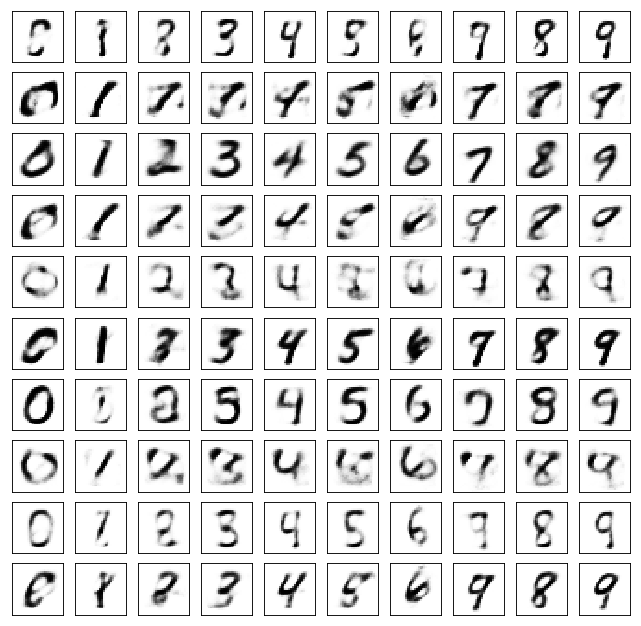

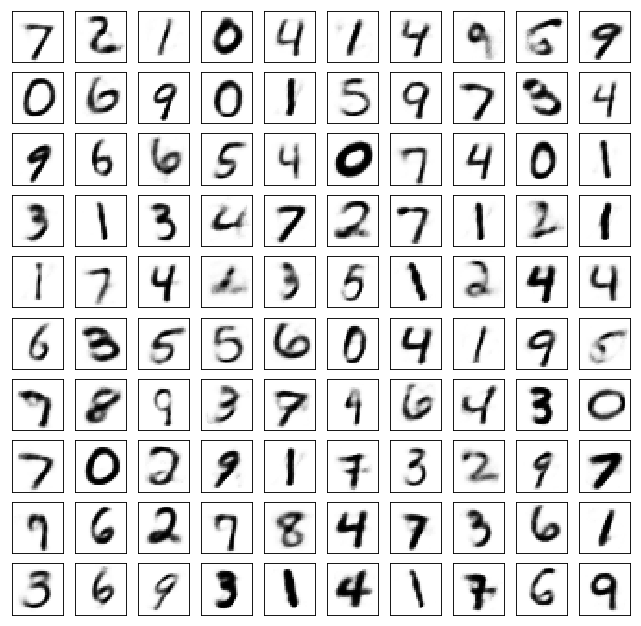

AAE with label in latent


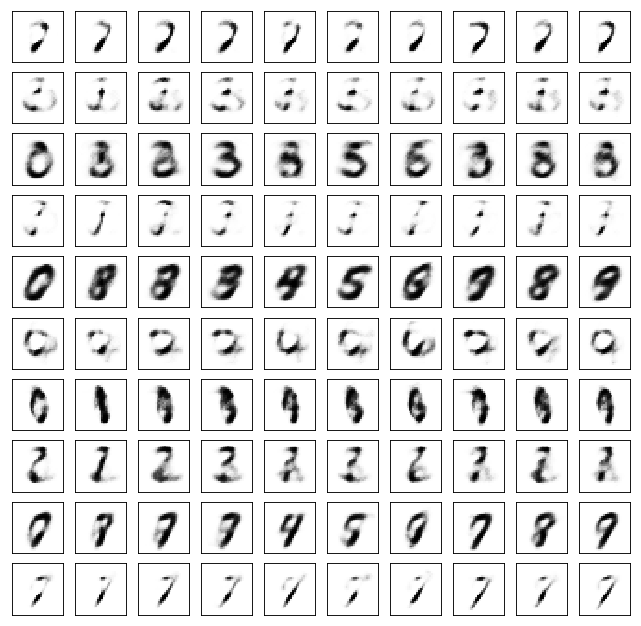

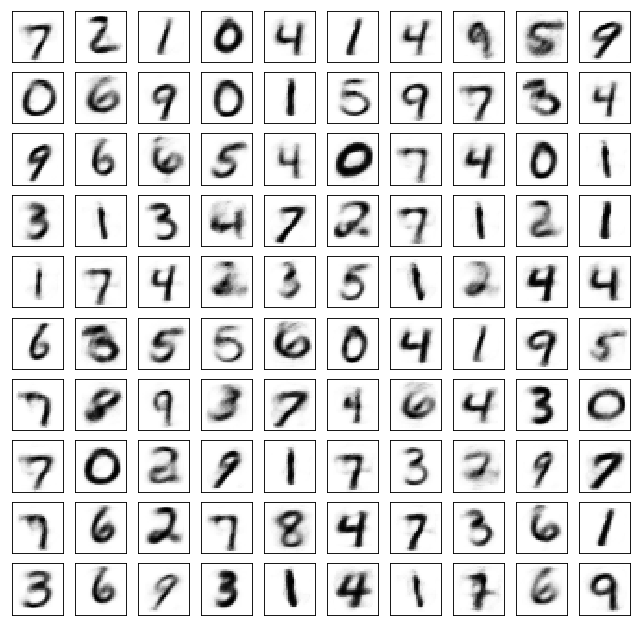

In [112]:
print('True CAAE')
fixed_gen_t = Dec_true(fixed_z, fixed_z_label).cpu().data.numpy().reshape(100, 1, 28, 28)
plot_mnist(fixed_gen_t, (10, 10), True, fixed_folder + '%03d.png' % epoch)
fixed_reconstruction_t = Dec_true(Enc_true(fixed_data), fixed_label).cpu().data.numpy().reshape(100, 1, 28, 28)
plot_mnist(fixed_reconstruction_t, (10, 10), True, recon_folder + '%03d.png' % epoch)

print('AAE with label in latent')
fixed_gen = Dec(fixed_z, fixed_z_label).cpu().data.numpy().reshape(100, 1, 28, 28)
plot_mnist(fixed_gen, (10, 10), True, fixed_folder + '%03d.png' % epoch)
fixed_reconstruction = Dec(Enc(fixed_data), fixed_label).cpu().data.numpy().reshape(100, 1, 28, 28)
plot_mnist(fixed_reconstruction, (10, 10), True, recon_folder + '%03d.png' % epoch)

In [ ]:
##CLSFR

In [113]:
batch_size_clsf = 50
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size_clsf, valid=10000, transform=mnist_tanh)

In [114]:
class Net_clsf(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-2, l2=0.):
        super(Net_clsf, self).__init__()
        self.fc1 = nn.Linear(28*28, 28*28)
        self.fc2 = nn.Linear(28*28, 28*14)
        self.fc3 = nn.Linear(28*14 , 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(28*28)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        #self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        self.optim = optim.SGD(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = torch.tanh(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [115]:
models = {'clsf': Net_clsf(True, True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}


In [116]:
def train_clsf(epoch, models):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        #print(batch_idx)
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            #print(output.size())
            #print(target.size())
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

In [117]:
def test_clsf(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='mean').item() # sum up batch loss
                #test_loss[k] += m.loss(output, target).item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [36]:
for epoch in range(1, 100):
    for model in models.values():
        model.train()
    train_clsf(epoch, models)
    for model in models.values():
        model.eval()
    test_clsf(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses clsf: 0.348236
Train Epoch: 1 [10000/50000 (20%)]	Losses clsf: 0.234506
Train Epoch: 1 [20000/50000 (40%)]	Losses clsf: 0.218917
Train Epoch: 1 [30000/50000 (60%)]	Losses clsf: 0.277821
Train Epoch: 1 [40000/50000 (80%)]	Losses clsf: 0.360828
Train Epoch: 1 [50000/50000 (100%)]	Losses clsf: 0.182244
Test set:
clsf: Loss: 0.0052	Accuracy: 9242/10000 (92%)

Train Epoch: 2 [0/50000 (0%)]	Losses clsf: 0.225262
Train Epoch: 2 [10000/50000 (20%)]	Losses clsf: 0.333364
Train Epoch: 2 [20000/50000 (40%)]	Losses clsf: 0.166363
Train Epoch: 2 [30000/50000 (60%)]	Losses clsf: 0.260455
Train Epoch: 2 [40000/50000 (80%)]	Losses clsf: 0.154484
Train Epoch: 2 [50000/50000 (100%)]	Losses clsf: 0.143315
Test set:
clsf: Loss: 0.0044	Accuracy: 9373/10000 (93%)

Train Epoch: 3 [0/50000 (0%)]	Losses clsf: 0.176706
Train Epoch: 3 [10000/50000 (20%)]	Losses clsf: 0.343678
Train Epoch: 3 [20000/50000 (40%)]	Losses clsf: 0.413063
Train Epoch: 3 [30000/50000 (60%)]	Losses cl

KeyboardInterrupt: 

In [ ]:
# FROM DATASET
#Train Epoch: 5 clsf: Loss: 0.0027	Accuracy: 9600/10000 (96%)

In [118]:
class Net_clsf_from_cnn(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-2, l2=0.):
        super(Net_clsf_from_cnn, self).__init__()
        self.fc1 = nn.Linear(prior_size, 28*28)
        self.fc2 = nn.Linear(28*28, 28*14)
        self.fc3 = nn.Linear(28*14 , 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(28*28)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        #self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        self.optim = optim.SGD(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        #x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = torch.tanh(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [122]:
models = {'clsf_cnn': Net_clsf_from_cnn(True, True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [120]:
def train_clsf_from_cnn(epoch, models, cnn_type):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        #print(batch_idx)
        for k, model in models.items():
            if cnn_type is 1:
                latent = Enc(data)
            else: latent = Enc_true(data) 
            model.optim.zero_grad()
            output = model(latent)
            #print(output.size())
            #print(target.size())
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

In [121]:
def test_clsf_from_cnn(models_from_cnn, loader, cnn_type, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                if cnn_type is 1:
                    latent = Enc(data)
                else: latent = Enc_true(data)
                output = m(latent)
                test_loss[k] += m.loss(output, target, reduction='mean').item() # sum up batch loss
                #test_loss[k] += m.loss(output, target).item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [123]:
for epoch in range(1, 100):
    for model in models.values():
        model.train()
    train_clsf_from_cnn(epoch, models, 1)
    for model in models.values():
        model.eval()
    test_clsf_from_cnn(models, valid_loader, 1 , test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses clsf_cnn: 2.256716
Train Epoch: 1 [10000/50000 (20%)]	Losses clsf_cnn: 1.451702
Train Epoch: 1 [20000/50000 (40%)]	Losses clsf_cnn: 1.483642
Train Epoch: 1 [30000/50000 (60%)]	Losses clsf_cnn: 1.351706
Train Epoch: 1 [40000/50000 (80%)]	Losses clsf_cnn: 1.115303
Train Epoch: 1 [50000/50000 (100%)]	Losses clsf_cnn: 1.156639
Test set:
clsf_cnn: Loss: 0.0211	Accuracy: 6362/10000 (63%)

Train Epoch: 2 [0/50000 (0%)]	Losses clsf_cnn: 1.148281
Train Epoch: 2 [10000/50000 (20%)]	Losses clsf_cnn: 1.131973
Train Epoch: 2 [20000/50000 (40%)]	Losses clsf_cnn: 1.215585
Train Epoch: 2 [30000/50000 (60%)]	Losses clsf_cnn: 1.130717
Train Epoch: 2 [40000/50000 (80%)]	Losses clsf_cnn: 0.789207
Train Epoch: 2 [50000/50000 (100%)]	Losses clsf_cnn: 1.003081
Test set:
clsf_cnn: Loss: 0.0185	Accuracy: 6804/10000 (68%)

Train Epoch: 3 [0/50000 (0%)]	Losses clsf_cnn: 1.208930
Train Epoch: 3 [10000/50000 (20%)]	Losses clsf_cnn: 0.974644
Train Epoch: 3 [20000/50000 (40%)]	Lo

Train Epoch: 20 [20000/50000 (40%)]	Losses clsf_cnn: 0.619710
Train Epoch: 20 [30000/50000 (60%)]	Losses clsf_cnn: 0.581977
Train Epoch: 20 [40000/50000 (80%)]	Losses clsf_cnn: 0.466624
Train Epoch: 20 [50000/50000 (100%)]	Losses clsf_cnn: 0.598963
Test set:
clsf_cnn: Loss: 0.0110	Accuracy: 8139/10000 (81%)

Train Epoch: 21 [0/50000 (0%)]	Losses clsf_cnn: 0.479839
Train Epoch: 21 [10000/50000 (20%)]	Losses clsf_cnn: 0.578447
Train Epoch: 21 [20000/50000 (40%)]	Losses clsf_cnn: 0.696209
Train Epoch: 21 [30000/50000 (60%)]	Losses clsf_cnn: 0.795613
Train Epoch: 21 [40000/50000 (80%)]	Losses clsf_cnn: 0.729334
Train Epoch: 21 [50000/50000 (100%)]	Losses clsf_cnn: 0.643462
Test set:
clsf_cnn: Loss: 0.0109	Accuracy: 8085/10000 (80%)

Train Epoch: 22 [0/50000 (0%)]	Losses clsf_cnn: 0.516959
Train Epoch: 22 [10000/50000 (20%)]	Losses clsf_cnn: 0.503495
Train Epoch: 22 [20000/50000 (40%)]	Losses clsf_cnn: 0.539854
Train Epoch: 22 [30000/50000 (60%)]	Losses clsf_cnn: 0.519337
Train Epoch: 22 [4

KeyboardInterrupt: 

In [ ]:
# FROM AAEC_C (with label inform)
# Train Epoch: 30  Loss: 0.0103	Accuracy: 8218/10000 (82%)

In [124]:
for epoch in range(1, 100):
    for model in models.values():
        model.train()
    train_clsf_from_cnn(epoch, models, 2)
    for model in models.values():
        model.eval()
    test_clsf_from_cnn(models, valid_loader, 2 , test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses clsf_cnn: 7.641610
Train Epoch: 1 [10000/50000 (20%)]	Losses clsf_cnn: 2.704204
Train Epoch: 1 [20000/50000 (40%)]	Losses clsf_cnn: 2.321361
Train Epoch: 1 [30000/50000 (60%)]	Losses clsf_cnn: 2.426775
Train Epoch: 1 [40000/50000 (80%)]	Losses clsf_cnn: 2.187852
Train Epoch: 1 [50000/50000 (100%)]	Losses clsf_cnn: 1.990180
Test set:
clsf_cnn: Loss: 0.0425	Accuracy: 2445/10000 (24%)

Train Epoch: 2 [0/50000 (0%)]	Losses clsf_cnn: 2.104802
Train Epoch: 2 [10000/50000 (20%)]	Losses clsf_cnn: 1.891549
Train Epoch: 2 [20000/50000 (40%)]	Losses clsf_cnn: 2.133879
Train Epoch: 2 [30000/50000 (60%)]	Losses clsf_cnn: 2.085020
Train Epoch: 2 [40000/50000 (80%)]	Losses clsf_cnn: 1.962495
Train Epoch: 2 [50000/50000 (100%)]	Losses clsf_cnn: 2.101928
Test set:
clsf_cnn: Loss: 0.0393	Accuracy: 3043/10000 (30%)

Train Epoch: 3 [0/50000 (0%)]	Losses clsf_cnn: 1.772998
Train Epoch: 3 [10000/50000 (20%)]	Losses clsf_cnn: 2.127237
Train Epoch: 3 [20000/50000 (40%)]	Lo

Train Epoch: 20 [20000/50000 (40%)]	Losses clsf_cnn: 1.487136
Train Epoch: 20 [30000/50000 (60%)]	Losses clsf_cnn: 1.464710
Train Epoch: 20 [40000/50000 (80%)]	Losses clsf_cnn: 1.307476
Train Epoch: 20 [50000/50000 (100%)]	Losses clsf_cnn: 1.211923
Test set:
clsf_cnn: Loss: 0.0256	Accuracy: 5547/10000 (55%)

Train Epoch: 21 [0/50000 (0%)]	Losses clsf_cnn: 1.251733
Train Epoch: 21 [10000/50000 (20%)]	Losses clsf_cnn: 1.375160
Train Epoch: 21 [20000/50000 (40%)]	Losses clsf_cnn: 1.485008
Train Epoch: 21 [30000/50000 (60%)]	Losses clsf_cnn: 1.189550
Train Epoch: 21 [40000/50000 (80%)]	Losses clsf_cnn: 1.119035
Train Epoch: 21 [50000/50000 (100%)]	Losses clsf_cnn: 1.047207
Test set:
clsf_cnn: Loss: 0.0252	Accuracy: 5612/10000 (56%)

Train Epoch: 22 [0/50000 (0%)]	Losses clsf_cnn: 1.054284
Train Epoch: 22 [10000/50000 (20%)]	Losses clsf_cnn: 1.295591
Train Epoch: 22 [20000/50000 (40%)]	Losses clsf_cnn: 1.283008
Train Epoch: 22 [30000/50000 (60%)]	Losses clsf_cnn: 1.191716
Train Epoch: 22 [4

KeyboardInterrupt: 

In [ ]:
# FROM CAAE -  классифицируется существенно хуже, распутывание произошло
# Train Epoch: 30 clsf_cnn: Loss: 0.0238	Accuracy: 5863/10000 (58%)